<a href="https://colab.research.google.com/github/animaviridis/evaluation_of_ai/blob/master/Competition_startingPoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Mining and Visualisation 2019-2020
Practical 6 - Time Series Classification & Competition

In [4]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
#from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from numpy import mean
import numpy as np
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from keras.layers import Dropout, LeakyReLU, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D, GlobalMaxPooling1D, BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
import math
from keras.optimizers import  Adam, SGD, RMSprop
from keras.regularizers import l1
from keras import backend as K
from keras.utils import multi_gpu_model
from keras import backend as K
import io
from google.colab import files
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [5]:
path = '/content'
# df = pd.read_csv('all_data_35predicitors_197k_rain_395k_nonrain.txt')
df = pd.read_csv(io.StringIO(files.upload()['all_data_35predicitors_197k_rain_395k_nonrain.txt'].decode('utf-8')))


Saving all_data_35predicitors_197k_rain_395k_nonrain.txt to all_data_35predicitors_197k_rain_395k_nonrain.txt


In [9]:
# Check that no nans or missing data
df.isnull().sum().sum()


0

In [0]:
# Change rain or no rain into True or False
df.PRECIP = df.PRECIP.astype(bool)

# Define preprocessor to change string to number labels
le = preprocessing.LabelEncoder()

# Change true/false to 1 or 0
df.PRECIP = le.fit_transform(df.PRECIP)

In [14]:
df.PRECIP

0         1
1         1
2         1
3         1
4         1
         ..
593869    0
593870    0
593871    0
593872    0
593873    0
Name: PRECIP, Length: 593874, dtype: int64

In [10]:
# See how many 1s and 0s there are in the data
label_distribution = {val: (df.PRECIP==val).sum() for val in set(df.PRECIP)}
label_distribution

{0: 395916, 1: 197958}

In [11]:
# percentages
{val: np.around(100*num/df.shape[0], 2) for val, num in label_distribution.items()}

{0: 66.67, 1: 33.33}

In [12]:
# Create datetime for reference and then remove from dataframe
datetime = df.DATE_TIME
df.drop(['DATE_TIME'], axis=1, inplace=True)

# Remove site-id
df.drop(['SITE_ID'], axis=1, inplace=True)

# Prepare data
X = df.drop('PRECIP', axis=1)  # Predictors
y = df.PRECIP  # Labels

# Normalize predictors
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

# Define test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1,shuffle=True)
y_test.value_counts()  # Check roughly equal amounts of rain or no rain in the test data


0    79363
1    39412
Name: PRECIP, dtype: int64

In [0]:
#datax = X_train.reshape(4410,1,52,1)
#datay = y_train.reshape()
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
y_train = np.array(y_train).reshape(X_train.shape[0],1)


In [0]:
#input_shape=len(df.columns)-1
K.clear_session()

In [19]:
y[300000]

0

Train on 380079 samples, validate on 95020 samples
Epoch 1/50
380079/380079 [==============================] - 52s 136us/step - loss: 0.6704 - acc: 0.6463 - val_loss: 0.5785 - val_acc: 0.6868

Epoch 00001: val_loss improved from inf to 0.57852, saving model to weights-improvement-01-0.69.hdf5
Epoch 2/50
380079/380079 [==============================] - 49s 129us/step - loss: 0.6478 - acc: 0.6613 - val_loss: 0.5682 - val_acc: 0.6937

Epoch 00002: val_loss improved from 0.57852 to 0.56816, saving model to weights-improvement-02-0.69.hdf5
Epoch 3/50
380079/380079 [==============================] - 49s 128us/step - loss: 0.6391 - acc: 0.6673 - val_loss: 0.5650 - val_acc: 0.6975

Epoch 00003: val_loss improved from 0.56816 to 0.56498, saving model to weights-improvement-03-0.70.hdf5
Epoch 4/50
380079/380079 [==============================] - 49s 128us/step - loss: 0.6352 - acc: 0.6693 - val_loss: 0.5612 - val_acc: 0.7011

Epoch 00004: val_loss improved from 0.56498 to 0.56121, saving model t

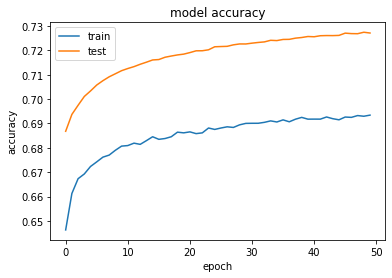

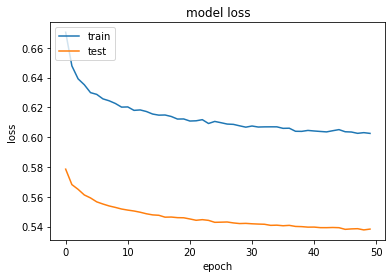

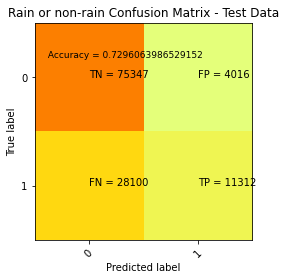

In [31]:
model = Sequential()

model.add(Conv1D(filters=32, padding='same', kernel_initializer='glorot_normal',input_shape=(X_train.shape[1],1), kernel_size=5))#filters= 16
model.add(LeakyReLU(alpha=0.3))
model.add(BatchNormalization(momentum=0.99, epsilon=0.001,scale=False))
#model.add(MaxPooling1D())
model.add(Conv1D(filters=64,  padding='same',kernel_initializer='glorot_normal', kernel_size=9))#filters = 32
model.add(LeakyReLU(alpha=0.3))
model.add(BatchNormalization(momentum=0.99, epsilon=0.001,scale=False))
model.add(MaxPooling1D())
model.add(Conv1D(filters=128,  padding='same',kernel_initializer='glorot_normal', kernel_size=9))
model.add(LeakyReLU(alpha=0.3))
model.add(BatchNormalization(momentum=0.99, epsilon=0.001, scale=False))
model.add(Dropout(0.4))
#model.add(Conv1D(filters=128, kernel_size=5,activation='relu'))
#model.add(BatchNormalization(momentum=0.99, epsilon=0.001, scale=False))
#model.add(Dropout(0.4))
model.add(Conv1D(filters=196,  padding='same',kernel_initializer='glorot_normal', kernel_size=9))
model.add(LeakyReLU(alpha=0.3))
model.add(BatchNormalization(momentum=0.99, epsilon=0.001, scale=False))
model.add(Dropout(0.4))
model.add(MaxPooling1D())
model.add(Conv1D(filters=196, padding='same',kernel_initializer='glorot_normal', kernel_size=9))
model.add(LeakyReLU(alpha=0.3))
model.add(BatchNormalization(momentum=0.99, epsilon=0.001,  scale=False))
model.add(Conv1D(filters=196, padding='same',kernel_initializer='glorot_normal', kernel_size=9))
model.add(LeakyReLU(alpha=0.3))
model.add(BatchNormalization(momentum=0.99, epsilon=0.001,  scale=False))
model.add(Dropout(0.4))
model.add(Conv1D(filters=196, padding='same',kernel_initializer='glorot_normal', kernel_size=9))
model.add(LeakyReLU(alpha=0.3))
model.add(BatchNormalization(momentum=0.99, epsilon=0.001, scale=False))
model.add(Dropout(0.4))
model.add(MaxPooling1D())

model.add(Conv1D(filters=256, padding='same',kernel_initializer='glorot_normal', kernel_size=9))
model.add(LeakyReLU(alpha=0.3))
model.add(BatchNormalization(momentum=0.99, epsilon=0.001, scale=False))
model.add(Dropout(0.4))
model.add(Conv1D(filters=256, padding='same',kernel_initializer='glorot_normal', kernel_size=9))
model.add(LeakyReLU(alpha=0.3))
model.add(BatchNormalization(momentum=0.99, epsilon=0.001, scale=False))
model.add(Conv1D(filters=256, padding='same',kernel_initializer='glorot_normal', kernel_size=9))
model.add(LeakyReLU(alpha=0.3))
model.add(BatchNormalization(momentum=0.99, epsilon=0.001, scale=False))
#model.add(Dropout(0.4))
#model.add(Conv1D(filters=196, kernel_size=5, activation='relu'))
#model.add(BatchNormalization(momentum=0.99, epsilon=0.001, scale=False))
#model.add(Dropout(0.4))
model.add(Flatten())

#model.add(GlobalAveragePooling1D())
#model.add(GlobalMaxPooling1D())

model.add(Dense(1024, kernel_initializer='glorot_normal'))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.3))
model.add(Dense(512, kernel_initializer='glorot_normal'))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.3))

model.add(Dense(1, kernel_initializer='glorot_normal', activation='sigmoid'))

#Set optimizer
sgd = SGD(lr=0.001, momentum=0.9, decay=0.1, nesterov=True)
#adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.99)
#rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
#Compile
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])


#'''Define callbacks'''

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                             # patience=1, min_lr=0.001)
#Do exponential reduction of lr, start at 0.5
#
#earlyStop=EarlyStopping(monitor='acc', min_delta=0.01, patience=50, verbose=1,
                               #mode='auto', baseline=None, restore_best_weights=True)
##Learning rate exponential
#def exp_decay(epoch):
  # initial_lrate = 0.5
   #k = 0.1
  # lrate = initial_lrate * math.exp(-k*epoch)
  # return lrate
#lrate = LearningRateScheduler(exp_decay)


#callbacks_list = [earlyStop] # callbacks=callbacks_list
filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
#Fit model
checkpoint = ModelCheckpoint(filepath, save_best_only=True,  save_weights_only=False, verbose=1, mode='min', period=1)
callbacks_list = [checkpoint]
mod=model.fit(X_train, y_train, validation_split=0.20, epochs=50, batch_size=512,verbose=1, callbacks=callbacks_list)

 #Make predictions
y_pred=model.predict(X_test)

#Convert predictions to usable series with correct index
y_pred=[float(round(x[0])) for x in y_pred]#round probabilites
y_pred=pd.Series(y_pred)#Change to series
new_index=y_pred.index.values #Take index from known test data
y_test.index=new_index #Apply new index to predictions
accuracy = mean(y_pred == y_test)
print("Prediction Accuracy: %.2f%%" % (accuracy*100))


'''Check and plot history'''
print(mod.history.keys())


plt.plot(mod.history['acc'])
plt.plot(mod.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(mod.history['loss'])
plt.plot(mod.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



#'''Evaluating across all data with k fold'''
#seed=9
#estimator = KerasClassifier(build_fn=model, epochs=10, batch_size=5, verbose=0)
#kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
#results = cross_val_score(estimator, X, y, cv=kfold)
#print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


'''Plot confusion matrix'''
cm=confusion_matrix(y_test, y_pred)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1'] #Check class names
plt.title('Rain or non-rain Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.annotate(' Accuracy = {}'.format(accuracy), size=9,
             xy=(xmin,ymax), xytext=(10, -35), textcoords='offset points')
plt.show()


In [21]:
y_pred

0         0.0
1         1.0
2         0.0
3         1.0
4         0.0
         ... 
118770    0.0
118771    0.0
118772    0.0
118773    0.0
118774    0.0
Length: 118775, dtype: float64

In [22]:
y_test

0         0
1         1
2         0
3         1
4         0
         ..
118770    0
118771    1
118772    0
118773    0
118774    0
Name: PRECIP, Length: 118775, dtype: int64

In [28]:
accuracy

0.7539717954114923

In [29]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=2a93f752dd8ef2225e4534cbf6bcaae37665a96692c9df8b14c3e945fe819410
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 11.8 GB  | Proc size: 2.9 GB
GPU RAM Free: 4024MB | Used: 3587MB | Util  47% | Total 7611MB


In [30]:
gpu